<p style="text-align: center;"><img alt="school-logo" src="../images/school_logo.png" style="zoom: 50%;" /></p>

<h1 align="center">本科生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">前馈神经网络实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">21281280</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">班级</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">物联网2101班</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">指导老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">张淳杰</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2023年10月24日</span></div>
</div>

实验环境：
- OS：WSL2 Ubuntu-22.04 (Kernel: 5.15.90.1-microsoft-standard-WSL2)
- CPU：12th Gen Intel(R) Core(TM) i7-12700H
- GPU：NVIDIA GeForce RTX 3070 Ti Laptop
- cuda: 12.3
- conda: miniconda 23.9.0
- python：3.10.13
- pytorch：2.1.0

In [1]:
import time
import numpy as np
import torch
from torch.nn.functional import *
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

引用相关库。

# 任务一
**手动实现前馈神经网络解决上述回归、二分类、多分类任务。**
- 从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

首先生成数据集。

一共有3个数据集：

1. 回归任务数据集。
   - 生成单个数据集。
   - 数据集的大小为$10000$且训练集大小为$7000$，测试集大小为$3000$。
   - 数据集的样本特征维度$p$为$500$，且服从如下的高维线性函数：$y = 0.028 + \sum_{p}^{i=1}0.0056 x_i + \epsilon $。
2. 二分类任务数据集。
   - 共生成两个数据集。
   - 两个数据集的大小均为$10000$且训练集大小为$7000$，测试集大小为$3000$。
   - 两个数据集的样本特征$x$的维度均为$200$，且分别服从均值互为相反数且方差相同的正态分布。
   - 两个数据集的样本标签分别为$0$和$1$。
3. MNIST手写体数据集。
   - 该数据集包含$60,000$个用于训练的图像样本和$10,000$个用于测试的图像样本。
   - 图像是固定大小（$28\times 28$像素），其值为$0$到$1$。为每个图像都被平展并转换为$784$（$28 \times 28$）个特征的一维numpy数组。 

实现回归任务数据集。

In [2]:
class My_Regression_Dataset(Dataset):
    def __init__(self, train=True):
        data_size = 7000 if train else 3000
        np.random.seed(0)
        x = np.random.rand(data_size, 500) * 0.005
        noise = np.random.randn(data_size) * 1e-7
        y = 0.028 - 0.0056 * x.sum(axis=1) + noise
        y = y.reshape(-1, 1)
        self.data = [[x[i], y[i]] for i in range(x.shape[0])]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x, y = self.data[index]
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y)
        return x, y

        
# 测试，并后面的训练创建变量
train_regression_dataset = My_Regression_Dataset(train=True)
test_regression_dataset = My_Regression_Dataset(train=False)

train_regression_dataset_size = len(train_regression_dataset)
test_regression_dataset_size = len(test_regression_dataset)
print(f"训练数据集大小：{train_regression_dataset_size}，测试数据集大小：{test_regression_dataset_size}")
x0, y0 = train_regression_dataset[0]
print(f"训练数据集的第1对数据：")
print(f"x[0]第1个特征维度数据x[0][0] = {x0[0]}")
print(f"y[0] = {y0}")

训练数据集大小：7000，测试数据集大小：3000
训练数据集的第1对数据：
x[0]第1个特征维度数据x[0][0] = 0.002744067460298538
y[0] = tensor([0.0210])


实现二分类任务数据集。

In [3]:
class My_BinaryCLS_Dataset(Dataset):
    def __init__(self, train=True, num_features=200):
        num_samples = 7000 if train else 3000
        
        x_1 = np.random.normal(loc=-0.5, scale=0.2, size=(num_samples, num_features))
        x_2 = np.random.normal(loc=0.5, scale=0.2, size=(num_samples, num_features))
        
        labels_1 = np.zeros((num_samples, 1))
        labels_2 = np.ones((num_samples, 1))
        
        x = np.concatenate((x_1, x_2), axis=0)
        labels = np.concatenate((labels_1, labels_2), axis=0)
        self.data = [[x[i], labels[i]] for i in range(2 * num_samples)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x, y = self.data[index]
        x = torch.FloatTensor(x)
        y = torch.LongTensor(y)
        return x, y


# 测试，并后面的训练创建变量
train_binarycls_dataset = My_BinaryCLS_Dataset(train=True)
test_binarycls_dataset = My_BinaryCLS_Dataset(train=False)

train_binarycls_dataset_size = len(train_binarycls_dataset)
test_binarycls_dataset_size = len(test_binarycls_dataset)
print(f"训练数据集大小：{train_binarycls_dataset_size}，测试数据集大小：{test_binarycls_dataset_size}")
x0, y0 = train_binarycls_dataset[0]
print(f"训练数据集的第1对数据：")
print(f"x[0]第1个特征维度数据x[0][0] = {x0[0]}")
print(f"y[0] = {y0}")

x7000, y7000 = train_binarycls_dataset[7000]
print(f"训练数据集的第7001对数据：")
print(f"x[7000]第1个特征维度数据x[7000][0] = {x7000[0]}")
print(f"y[7000] = {y7000}")

训练数据集大小：14000，测试数据集大小：6000
训练数据集的第1对数据：
x[0]第1个特征维度数据x[0][0] = -0.519691526889801
y[0] = tensor([0])
训练数据集的第7001对数据：
x[7000]第1个特征维度数据x[7000][0] = 0.3035626709461212
y[7000] = tensor([1])


使用MNIST数据集。

首先造一个展示图片的函数。

In [4]:
def imshow(img):
    img = img.squeeze().numpy()
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

调用`torchvision.datasets.MNIST()`，获取数据集。

训练数据集大小：60000，测试数据集大小：10000
训练数据集的第1对数据：
x[0]第1个特征维度数据x[0]的大小 = torch.Size([1, 28, 28])
y[0] = 5
x[0]的图像：


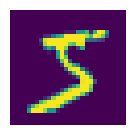

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_mnist_dataset = datasets.MNIST(root="dataset", train=True, transform=transform, download=True)
test_mnist_dataset = datasets.MNIST(root="dataset", train=False, transform=transform, download=True)

train_mnist_dataset_size = len(train_mnist_dataset)
test_mnist_dataset_size = len(test_mnist_dataset)
print(f"训练数据集大小：{train_mnist_dataset_size}，测试数据集大小：{test_mnist_dataset_size}")

x0, y0 = train_mnist_dataset[0]
print(f"训练数据集的第1对数据：")
print(f"x[0]第1个特征维度数据x[0]的大小 = {x0.shape}")
print(f"y[0] = {y0}")
print(f"x[0]的图像：")
imshow(x0)

接下来手动实现前馈神经网络并训练。

首先手动实现一些工具和基本模型层。这些工具都在前一个实验中实现并测试过，在此就不再分析其原理和具体实现步骤，也不在此重新测试。

In [6]:
# 手动实现torch.nn.functional.one_hot
def my_one_hot(indices: torch.Tensor, num_classes: int):
    one_hot_tensor = torch.zeros(len(indices), num_classes, dtype=torch.long).to(indices.device)
    one_hot_tensor.scatter_(1, indices.view(-1, 1), 1)
    return one_hot_tensor


# 手动实现torch.nn.functional.softmax
def my_softmax(predictions: torch.Tensor, dim: int):
    max_values = torch.max(predictions, dim=dim, keepdim=True).values
    exp_values = torch.exp(predictions - max_values)
    softmax_output = exp_values / torch.sum(exp_values, dim=dim, keepdim=True)
    return softmax_output


# 手动实现torch.nn.Linear
class My_Linear:
    def __init__(self, in_features: int, out_features: int):
        self.weight = torch.normal(mean=0.001, std=0.5, size=(out_features, in_features), requires_grad=True, dtype=torch.float32)
        self.bias = torch.normal(mean=0.001, std=0.5, size=(1,), requires_grad=True, dtype=torch.float32)
        self.params = [self.weight, self.bias]

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = torch.matmul(x, self.weight.T) + self.bias
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params

        
# 手动实现torch.nn.Flatten
class My_Flatten:
    def __call__(self, x: torch.Tensor):
        x = x.view(x.shape[0], -1)
        return x

        
# 手动实现torch.nn.ReLU
class My_ReLU():
    def __call__(self, x: torch.Tensor):
        x = torch.max(x, torch.tensor(0.0, device=x.device))
        return x


# 手动实现torch.nn.Sigmoid
class My_Sigmoid():
    def __call__(self, x: torch.Tensor):
        x = 1. / (1. + torch.exp(-x))
        return x


# 手动实现torch.nn.BCELoss
class My_BCELoss:
    def __call__(self, prediction: torch.Tensor, target: torch.Tensor):
        loss = -torch.mean(target * torch.log(prediction) + (1 - target) * torch.log(1 - prediction))
        return loss


# 手动实现torch.nn.CrossEntropyLoss
class My_CrossEntropyLoss:
    def __call__(self, predictions: torch.Tensor, targets: torch.Tensor):
        max_values = torch.max(predictions, dim=1, keepdim=True).values
        exp_values = torch.exp(predictions - max_values)
        softmax_output = exp_values / torch.sum(exp_values, dim=1, keepdim=True)

        log_probs = torch.log(softmax_output)
        nll_loss = -torch.sum(targets * log_probs, dim=1)
        average_loss = torch.mean(nll_loss)
        return average_loss


# 手动实现torch.optim.SGD
class My_optimizer:
    def __init__(self, params: list[torch.Tensor], lr: float):
        self.params = params
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param.data = param.data - self.lr * param.grad.data

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data = torch.zeros_like(param.grad.data)

首先造一个显示训练损失和测试正确率的函数。

In [7]:
def draw_loss_and_acc(train_loss:list[float], test_acc:list[float]):
    # train loss
    plt.figure(figsize=(7, 3.5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    
    # test acc
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_acc, label='Test Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

手动构建回归任务的模型。

In [8]:
class Model_1_1:
    def __init__(self):
        self.linear = My_Linear(in_features=500, out_features=1)
        self.sigmoid = My_Sigmoid()
        self.params = self.linear.params

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params
    
    def train(self):
        for param in self.params:
            param.requires_grad = True
    
    def eval(self):
        for param in self.params:
            param.requires_grad = False

训练并测试上述回归模型。

本次实验不再逐epoch输出损失、正确率和时间，而是每5个epoch输出1次，每个模型训练21个epoch。

Epoch [1/21], Train Loss: 1.1030388400, Used Time: 1353.186ms, Test Acc: 35.957%, Used Time: 266.134ms
Epoch [6/21], Train Loss: 0.7133886367, Used Time: 260.719ms, Test Acc: 98.385%, Used Time: 276.593ms
Epoch [11/21], Train Loss: 0.7133838981, Used Time: 262.404ms, Test Acc: 98.545%, Used Time: 246.299ms
Epoch [16/21], Train Loss: 0.7133851796, Used Time: 269.623ms, Test Acc: 98.545%, Used Time: 253.705ms
Epoch [21/21], Train Loss: 0.7133822516, Used Time: 263.288ms, Test Acc: 98.545%, Used Time: 250.530ms


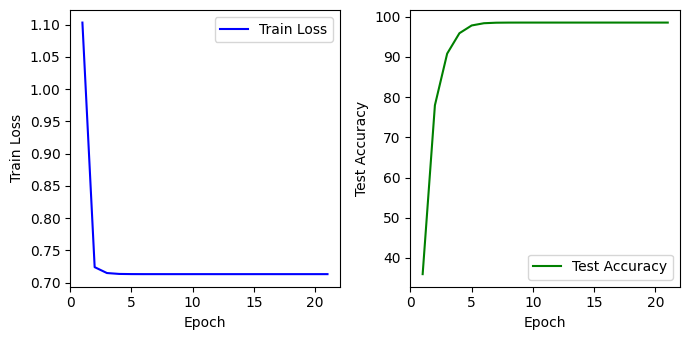

In [9]:
learning_rate = 5
num_epochs = 21
batch_size = 1024
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(dataset=train_regression_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
test_dataloader = DataLoader(dataset=test_regression_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

model = Model_1_1().to(device)
criterion = My_BCELoss()
optimizer = My_optimizer(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (x, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        x = x.to(device)
        targets = targets.to(device)
        
        y_pred = model(x)
        
        loss = criterion(y_pred, targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (x, targets) in enumerate(test_dataloader):
            x = x.to(device)
            targets = targets.to(device)
            
            y_pred = model(x)
            total_epoch_acc += (1 - torch.abs(y_pred - targets) / torch.abs(targets)).sum().item()
            
        end_time = time.time()
        test_time = end_time - start_time
        
    avg_epoch_acc = total_epoch_acc / len(test_regression_dataset)
    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}],",
            f"Train Loss: {total_epoch_loss:.10f},",
            f"Used Time: {train_time * 1000:.3f}ms,",
            f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
            f"Used Time: {test_time * 1000:.3f}ms",
        )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)

手动构建二分类任务的模型。

In [10]:
class Model_1_2:
    def __init__(self):
        self.fc = My_Linear(in_features=200, out_features=1)
        self.sigmoid = My_Sigmoid()
        self.params = self.fc.parameters()

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params
    
    def train(self):
        for param in self.params:
            param.requires_grad = True
    
    def eval(self):
        for param in self.params:
            param.requires_grad = False

训练并测试上述二分类模型。

Epoch [1/21], Train Loss: 32.8091183305, Used Time: 697.000ms, Test Acc: 52.767%, Used Time: 258.649ms
Epoch [6/21], Train Loss: 0.8007395566, Used Time: 290.056ms, Test Acc: 99.600%, Used Time: 257.690ms
Epoch [11/21], Train Loss: 0.3398014214, Used Time: 282.811ms, Test Acc: 99.983%, Used Time: 249.543ms
Epoch [16/21], Train Loss: 0.2110017957, Used Time: 280.831ms, Test Acc: 99.983%, Used Time: 261.706ms
Epoch [21/21], Train Loss: 0.1522123339, Used Time: 290.631ms, Test Acc: 100.000%, Used Time: 251.535ms


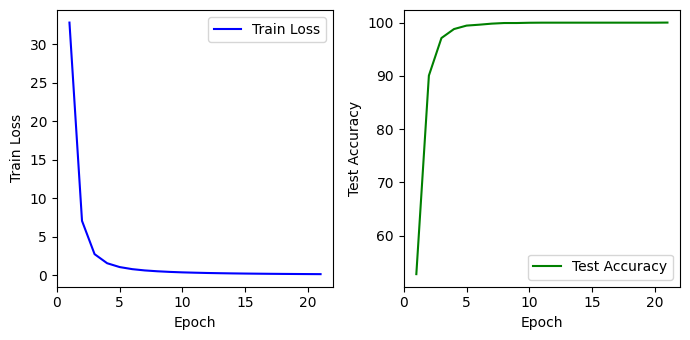

In [11]:
learning_rate = 8e-3
num_epochs = 21
batch_size = 1024
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(dataset=train_binarycls_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
test_dataloader = DataLoader(dataset=test_binarycls_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

model = Model_1_2().to(device)
criterion = My_BCELoss()
optimizer = My_optimizer(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (x, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        x = x.to(device)
        targets = targets.to(device).to(dtype=torch.float)
        
        y_pred = model(x)
        loss = criterion(y_pred, targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (x, targets) in enumerate(test_dataloader):
            x = x.to(device)
            targets = targets.to(device)
            
            output = model(x)
            pred = (output > 0.5).to(dtype=torch.long)
            total_epoch_acc += (pred == targets).sum().item()
            
        end_time = time.time()
        test_time = end_time - start_time

    avg_epoch_acc = total_epoch_acc / len(test_binarycls_dataset)
    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}],",
            f"Train Loss: {total_epoch_loss:.10f},",
            f"Used Time: {train_time * 1000:.3f}ms,",
            f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
            f"Used Time: {test_time * 1000:.3f}ms",
        )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)

手动构建MNIST多分类任务的模型。

In [12]:
class Model_1_3:
    def __init__(self, num_classes):
        self.flatten = My_Flatten()
        self.linear = My_Linear(in_features=28 * 28, out_features=num_classes)
        self.params = self.linear.params

    def __call__(self, x: torch.Tensor):
        return self.forward(x)

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params
    
    def train(self):
        for param in self.params:
            param.requires_grad = True
    
    def eval(self):
        for param in self.params:
            param.requires_grad = False

训练并测试上述MNIST多分类模型。

Epoch [1/21], Train Loss: 193.7902541161, Used Time: 917.054ms, Test Acc: 48.590%, Used Time: 425.420ms
Epoch [6/21], Train Loss: 37.7431737185, Used Time: 983.078ms, Test Acc: 77.800%, Used Time: 443.390ms
Epoch [11/21], Train Loss: 27.9078875780, Used Time: 983.323ms, Test Acc: 82.270%, Used Time: 426.247ms
Epoch [16/21], Train Loss: 23.6815550327, Used Time: 982.686ms, Test Acc: 84.340%, Used Time: 410.447ms
Epoch [21/21], Train Loss: 21.1408505440, Used Time: 946.963ms, Test Acc: 85.450%, Used Time: 385.761ms


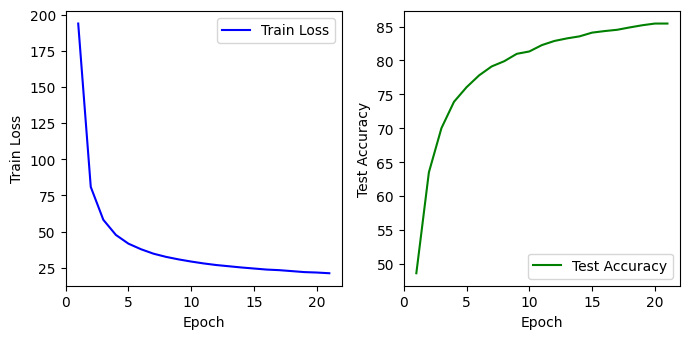

In [13]:
learning_rate = 1e-1
num_epochs = 21
batch_size = 2048
num_classes = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_loader = DataLoader(dataset=train_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
test_loader = DataLoader(dataset=test_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

model = Model_1_3(num_classes).to(device)
criterion = My_CrossEntropyLoss()
optimizer = My_optimizer(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)
        one_hot_targets = my_one_hot(targets, num_classes=num_classes).to(dtype=torch.float)

        outputs = model(images)
        loss = criterion(outputs, one_hot_targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (image, targets) in enumerate(test_loader):
            image = image.to(device)
            targets = targets.to(device)
            
            outputs = model(image)
            pred = my_softmax(outputs, dim=1)
            total_epoch_acc += (pred.argmax(1) == targets).sum().item()
        
        end_time = time.time()
        test_time = end_time - start_time
    
    avg_epoch_acc = total_epoch_acc / len(test_mnist_dataset)
    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}],",
            f"Train Loss: {total_epoch_loss:.10f},",
            f"Used Time: {train_time * 1000:.3f}ms,",
            f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
            f"Used Time: {test_time * 1000:.3f}ms",
        )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)

# 任务二
**利用torch.nn实现前馈神经网络解决上述回归、二分类、多分类任务。**
- 从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

使用`torch.nn`构建回归任务的模型。

In [14]:
class Model_2_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=500, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

训练并测试上述回归模型。

Epoch [1/21], Train Loss: 1.4070934802, Used Time: 286.710ms, Test Acc: 40.067%, Used Time: 255.361ms
Epoch [6/21], Train Loss: 0.7133745328, Used Time: 262.477ms, Test Acc: 99.014%, Used Time: 257.300ms
Epoch [11/21], Train Loss: 0.7133530825, Used Time: 272.271ms, Test Acc: 99.332%, Used Time: 260.335ms
Epoch [16/21], Train Loss: 0.7133620456, Used Time: 272.843ms, Test Acc: 99.332%, Used Time: 258.615ms
Epoch [21/21], Train Loss: 0.7133617774, Used Time: 267.960ms, Test Acc: 99.332%, Used Time: 260.866ms


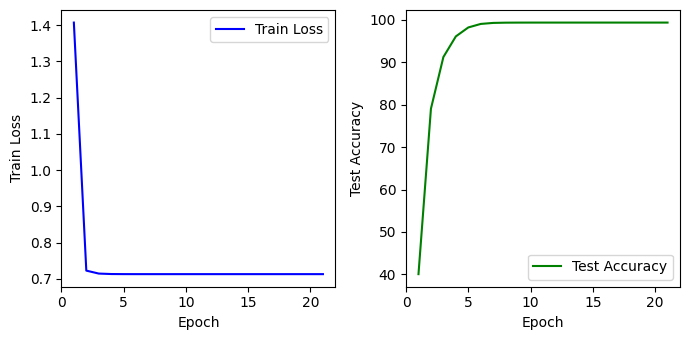

In [15]:
learning_rate = 5
num_epochs = 21
batch_size = 1024
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(dataset=train_regression_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
test_dataloader = DataLoader(dataset=test_regression_dataset, batch_size=batch_size, shuffle=True, num_workers=14,  pin_memory=True)

model = Model_2_1().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (x, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        x = x.to(device)
        targets = targets.to(device)
        
        y_pred = model(x)
        
        loss = criterion(y_pred, targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (x, targets) in enumerate(test_dataloader):
            x = x.to(device)
            targets = targets.to(device)
            
            y_pred = model(x)
            total_epoch_acc += (1 - torch.abs(y_pred - targets) / torch.abs(targets)).sum().item()
            
        end_time = time.time()
        test_time = end_time - start_time
        
    avg_epoch_acc = total_epoch_acc / len(test_regression_dataset)
    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}],",
            f"Train Loss: {total_epoch_loss:.10f},",
            f"Used Time: {train_time * 1000:.3f}ms,",
            f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
            f"Used Time: {test_time * 1000:.3f}ms",
        )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)

使用`torch.nn`构建二分类任务的模型。

In [16]:
class Model_2_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(in_features=200, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

训练并测试上述二分类模型。

Epoch [1/21], Train Loss: 8.2741773129, Used Time: 289.847ms, Test Acc: 97.267%, Used Time: 259.124ms
Epoch [6/21], Train Loss: 7.3801211119, Used Time: 291.994ms, Test Acc: 99.900%, Used Time: 252.881ms
Epoch [11/21], Train Loss: 6.6250074506, Used Time: 297.947ms, Test Acc: 100.000%, Used Time: 264.765ms
Epoch [16/21], Train Loss: 5.9835222065, Used Time: 297.365ms, Test Acc: 100.000%, Used Time: 265.306ms
Epoch [21/21], Train Loss: 5.4366103113, Used Time: 291.419ms, Test Acc: 100.000%, Used Time: 261.692ms


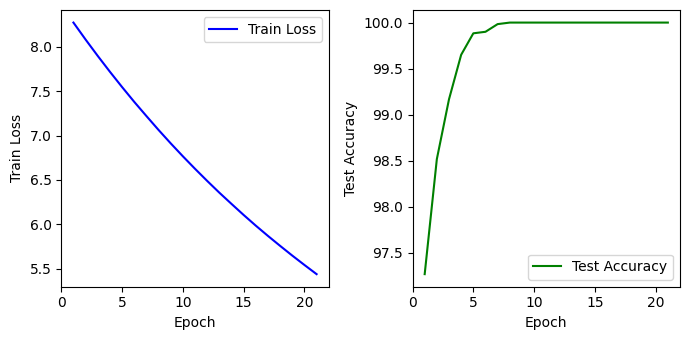

In [17]:
learning_rate = 1e-4
num_epochs = 21
batch_size = 1024
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(dataset=train_binarycls_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
test_dataloader = DataLoader(dataset=test_binarycls_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

model = Model_2_2().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (x, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()

        x = x.to(device)
        targets = targets.to(device).to(dtype=torch.float32)
        
        y_pred = model(x)
        loss = criterion(y_pred, targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (x, targets) in enumerate(test_dataloader):
            x = x.to(device)
            targets = targets.to(device)
            
            output = model(x)
            pred = (output > 0.5).to(dtype=torch.long)
            total_epoch_acc += (pred == targets).sum().item()
            
        end_time = time.time()
        test_time = end_time - start_time

    avg_epoch_acc = total_epoch_acc / len(test_binarycls_dataset)
    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}],",
            f"Train Loss: {total_epoch_loss:.10f},",
            f"Used Time: {train_time * 1000:.3f}ms,",
            f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
            f"Used Time: {test_time * 1000:.3f}ms",
        )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)

使用`torch.nn`构建MNIST多分类任务的模型。

In [18]:
class Model_2_3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=28 * 28, out_features=num_classes)

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.linear(x)
        return x

训练并测试上述MNIST多分类模型。

Epoch [1/21], Train Loss: 39.7126239538, Used Time: 1002.760ms, Test Acc: 77.470%, Used Time: 413.127ms
Epoch [6/21], Train Loss: 12.7497836053, Used Time: 988.396ms, Test Acc: 89.530%, Used Time: 415.606ms
Epoch [11/21], Train Loss: 11.1715984643, Used Time: 1025.708ms, Test Acc: 90.290%, Used Time: 439.041ms
Epoch [16/21], Train Loss: 10.4914320111, Used Time: 970.570ms, Test Acc: 90.670%, Used Time: 460.806ms
Epoch [21/21], Train Loss: 10.0342348516, Used Time: 984.248ms, Test Acc: 91.010%, Used Time: 418.183ms


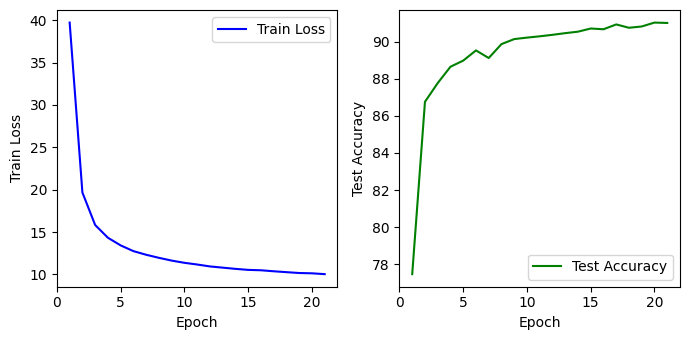

In [19]:
learning_rate = 5e-2
num_epochs = 21
batch_size = 2048
num_classes = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_loader = DataLoader(dataset=train_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True,)
test_loader = DataLoader(dataset=test_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14,pin_memory=True)

model = Model_2_3(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)
        one_hot_targets = one_hot(targets, num_classes=num_classes).to(dtype=torch.float)

        outputs = model(images)
        loss = criterion(outputs, one_hot_targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (image, targets) in enumerate(test_loader):
            image = image.to(device)
            targets = targets.to(device)
            
            outputs = model(image)
            pred = softmax(outputs, dim=1)
            total_epoch_acc += (pred.argmax(1) == targets).sum().item()
        
        end_time = time.time()
        test_time = end_time - start_time
    
    avg_epoch_acc = total_epoch_acc / len(test_mnist_dataset)
    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}],",
            f"Train Loss: {total_epoch_loss:.10f},",
            f"Used Time: {train_time * 1000:.3f}ms,",
            f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
            f"Used Time: {test_time * 1000:.3f}ms",
        )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)

# 任务三
**在多分类任务中使用至少三种不同的激活函数。**
- 使用不同的激活函数，进行对比实验并分析实验结果


首先定义一个训练函数。

我们将在接下来的测试中复用同一个训练过程，因此将训练过程封装成一个函数。每次使用时将模型传入训练函数，返回训练的损失变化和测试的正确率变化列表以画出其曲线即可。

In [20]:
def train_MNIST_CLS(Model:nn.Module):
    learning_rate = 8e-2
    num_epochs = 21
    batch_size = 2048
    num_classes = 10
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    
    train_loader = DataLoader(dataset=train_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
    test_loader = DataLoader(dataset=test_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

    model = Model(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    train_loss = list()
    test_acc = list()
    for epoch in range(num_epochs):
        model.train()
        total_epoch_loss = 0
        start_time = time.time()
        for index, (images, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            images = images.to(device)
            targets = targets.to(device)
            one_hot_targets = one_hot(targets, num_classes=num_classes).to(dtype=torch.float)

            outputs = model(images)
            loss = criterion(outputs, one_hot_targets)
            total_epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        end_time = time.time()
        train_time = end_time - start_time

        model.eval()
        with torch.no_grad():
            total_epoch_acc = 0
            start_time = time.time()
            for index, (image, targets) in enumerate(test_loader):
                image = image.to(device)
                targets = targets.to(device)
                
                outputs = model(image)
                pred = softmax(outputs, dim=1)
                total_epoch_acc += (pred.argmax(1) == targets).sum().item()
            
            end_time = time.time()
            test_time = end_time - start_time
        
        avg_epoch_acc = total_epoch_acc / len(test_mnist_dataset)
        if epoch % 5 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}],",
                f"Train Loss: {total_epoch_loss:.10f},",
                f"Used Time: {train_time * 1000:.3f}ms,",
                f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
                f"Used Time: {test_time * 1000:.3f}ms",
            )
        train_loss.append(total_epoch_loss)
        test_acc.append(avg_epoch_acc * 100)
    return train_loss, test_acc

接下来定义4个模型，分别使用`nn.functional.relu()`、`nn.functional.sigmoid()`、`nn.functional.tanh()`和`nn.functional.leaky_relu()`作为激活函数。

分别训练和测试。并将损失曲线和正确率曲线分别画在一个图内以进行比较4种激活函数的效果。

模型1开始训练，激活函数为relu：
Epoch [1/21], Train Loss: 61.8182386160, Used Time: 978.523ms, Test Acc: 49.980%, Used Time: 423.773ms
Epoch [6/21], Train Loss: 25.5127722025, Used Time: 982.802ms, Test Acc: 73.470%, Used Time: 436.265ms
Epoch [11/21], Train Loss: 15.8406201303, Used Time: 1054.201ms, Test Acc: 83.110%, Used Time: 439.752ms
Epoch [16/21], Train Loss: 14.4223749340, Used Time: 1017.818ms, Test Acc: 84.240%, Used Time: 447.467ms
Epoch [21/21], Train Loss: 13.3417748809, Used Time: 1017.753ms, Test Acc: 84.740%, Used Time: 414.742ms
模型2开始训练，激活函数为sigmoid：
Epoch [1/21], Train Loss: 69.0693337917, Used Time: 992.551ms, Test Acc: 11.350%, Used Time: 459.880ms
Epoch [6/21], Train Loss: 68.9371833801, Used Time: 1079.764ms, Test Acc: 11.350%, Used Time: 452.875ms
Epoch [11/21], Train Loss: 68.8318073750, Used Time: 1042.284ms, Test Acc: 11.350%, Used Time: 433.641ms
Epoch [16/21], Train Loss: 68.6989393234, Used Time: 1051.316ms, Test Acc: 11.350%, Used Time: 425.384ms
Epoch [21/21], Train 

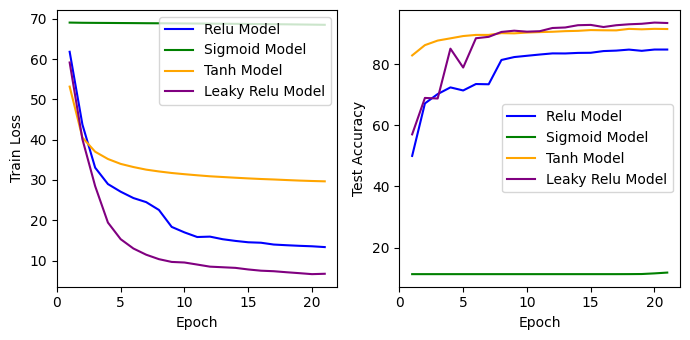

In [21]:
class Model_3_1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
        self.activate_fn = relu

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activate_fn(x)

        x = self.fc2(x)
        x = self.activate_fn(x)

        x = self.fc3(x)
        x = self.activate_fn(x)
        return x
    

class Model_3_2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
        self.activate_fn = sigmoid

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activate_fn(x)

        x = self.fc2(x)
        x = self.activate_fn(x)

        x = self.fc3(x)
        x = self.activate_fn(x)
        return x
    

class Model_3_3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
        self.activate_fn = tanh

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activate_fn(x)

        x = self.fc2(x)
        x = self.activate_fn(x)

        x = self.fc3(x)
        x = self.activate_fn(x)
        return x

class Model_3_4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
        self.activate_fn = leaky_relu

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activate_fn(x)

        x = self.fc2(x)
        x = self.activate_fn(x)

        x = self.fc3(x)
        x = self.activate_fn(x)
        return x
        

# 训练、测试并画图
print("模型1开始训练，激活函数为relu：")
train_loss_3_1, test_acc_3_1 = train_MNIST_CLS(Model=Model_3_1) # 激活函数为relu
print("模型2开始训练，激活函数为sigmoid：")
train_loss_3_2, test_acc_3_2 = train_MNIST_CLS(Model=Model_3_2) # 激活函数为sigmoid
print("模型3开始训练，激活函数为tanh：")
train_loss_3_3, test_acc_3_3 = train_MNIST_CLS(Model=Model_3_3) # 激活函数为tanh
print("模型4开始训练，激活函数为leaky_relu：")
train_loss_3_4, test_acc_3_4 = train_MNIST_CLS(Model=Model_3_4) # 激活函数为leaky_relu

# train loss
plt.figure(figsize=(7, 3.5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_3_1, label='Relu Model', color='blue')
plt.plot(range(1, num_epochs + 1), train_loss_3_2, label='Sigmoid Model', color='green')
plt.plot(range(1, num_epochs + 1), train_loss_3_3, label='Tanh Model', color='orange')
plt.plot(range(1, num_epochs + 1), train_loss_3_4, label='Leaky Relu Model', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()

# test acc
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_acc_3_1, label='Relu Model', color='blue')
plt.plot(range(1, num_epochs + 1), test_acc_3_2, label='Sigmoid Model', color='green')
plt.plot(range(1, num_epochs + 1), test_acc_3_3, label='Tanh Model', color='orange')
plt.plot(range(1, num_epochs + 1), test_acc_3_4, label='Leaky Relu Model', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

在性能表现上，激活函数为`sigmoid`的模型训练过程中损失下降速度非常慢，可见发生了梯度消失，这验证了`sigmoid`非常容易出现梯度消失的问题。

激活函数为`relu`的模型比较不稳定，有时会出现神经元死亡过多（值为$0$）的情况。

`tanh`以及`leaky relu`的表现相对优秀。

在用时上，`relu`训练的用时相较其他激活函数的用时平均少约$50\rm ms$，猜测是因为`relu`的计算量少。

# 任务四
**对多分类任务中的模型评估隐藏层层数和隐藏单元个数对实验结果的影响。**
- 使用不同的隐藏层层数和隐藏单元个数，进行对比实验并分析实验结果


接下来定义4个模型，隐藏层层数和隐藏单元个数分别如下：

- `Model_4_1`：hidden_size=512, hidden_layer=1
- `Model_4_2`：hidden_size=1024, hidden_layer=1
- `Model_4_3`：hidden_size=512, hidden_layer=2
- `Model_4_4`：hidden_size=1024, hidden_layer=2

分别训练和测试。并将损失曲线和正确率曲线分别画在一个图内以进行比较4个模型的效果。

模型1开始训练，hidden_size=512，hidden_layer=1 ：
Epoch [1/21], Train Loss: 46.8096676469, Used Time: 2256.211ms, Test Acc: 69.590%, Used Time: 586.215ms
Epoch [6/21], Train Loss: 11.3356736004, Used Time: 1152.953ms, Test Acc: 89.530%, Used Time: 520.603ms
Epoch [11/21], Train Loss: 9.1393958330, Used Time: 1139.308ms, Test Acc: 92.030%, Used Time: 746.556ms
Epoch [16/21], Train Loss: 8.0443021357, Used Time: 1113.647ms, Test Acc: 92.620%, Used Time: 474.136ms
Epoch [21/21], Train Loss: 7.1652033627, Used Time: 1088.146ms, Test Acc: 93.250%, Used Time: 449.901ms
模型2开始训练，hidden_size=1024，hidden_layer=1 ：
Epoch [1/21], Train Loss: 46.0817536116, Used Time: 1064.347ms, Test Acc: 74.630%, Used Time: 450.943ms
Epoch [6/21], Train Loss: 10.7080544233, Used Time: 1324.216ms, Test Acc: 90.230%, Used Time: 475.444ms
Epoch [11/21], Train Loss: 8.8931061625, Used Time: 1338.181ms, Test Acc: 91.680%, Used Time: 495.663ms
Epoch [16/21], Train Loss: 7.7604069710, Used Time: 1053.048ms, Test Acc: 93.020%, Us

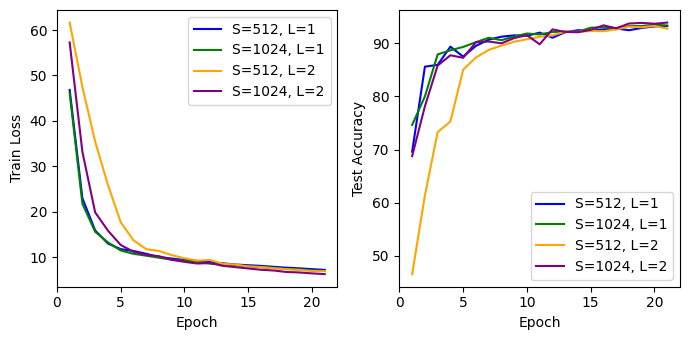

In [22]:
class Model_4_1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        self.activate_fn = leaky_relu

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activate_fn(x)

        x = self.fc2(x)
        x = self.activate_fn(x)
        return x
    

class Model_4_2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)
        self.activate_fn = leaky_relu

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activate_fn(x)

        x = self.fc2(x)
        x = self.activate_fn(x)
        return x
    

class Model_4_3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes)
        self.activate_fn = leaky_relu

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activate_fn(x)

        x = self.fc2(x)
        x = self.activate_fn(x)

        x = self.fc3(x)
        x = self.activate_fn(x)
        return x
    

class Model_4_4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=num_classes)
        self.activate_fn = leaky_relu

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activate_fn(x)

        x = self.fc2(x)
        x = self.activate_fn(x)

        x = self.fc3(x)
        x = self.activate_fn(x)
        return x


print("模型1开始训练，hidden_size=512，hidden_layer=1 ：")
train_loss_4_1, test_acc_4_1 = train_MNIST_CLS(Model=Model_4_1) # hidden_size=512, hidden_layer=1
print("模型2开始训练，hidden_size=1024，hidden_layer=1 ：")
train_loss_4_2, test_acc_4_2 = train_MNIST_CLS(Model=Model_4_2) # hidden_size=1024, hidden_layer=1
print("模型3开始训练，hidden_size=512，hidden_layer=2 ：")
train_loss_4_3, test_acc_4_3 = train_MNIST_CLS(Model=Model_4_3) # hidden_size=512, hidden_layer=2
print("模型4开始训练，hidden_size=1024，hidden_layer=2 ：")
train_loss_4_4, test_acc_4_4 = train_MNIST_CLS(Model=Model_4_4) # hidden_size=1024, hidden_layer=2

# train loss
plt.figure(figsize=(7, 3.5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_4_1, label='S=512, L=1', color='blue')
plt.plot(range(1, num_epochs + 1), train_loss_4_2, label='S=1024, L=1', color='green')
plt.plot(range(1, num_epochs + 1), train_loss_4_3, label='S=512, L=2', color='orange')
plt.plot(range(1, num_epochs + 1), train_loss_4_4, label='S=1024, L=2', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()

# test acc
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_acc_4_1, label='S=512, L=1', color='blue')
plt.plot(range(1, num_epochs + 1), test_acc_4_2, label='S=1024, L=1', color='green')
plt.plot(range(1, num_epochs + 1), test_acc_4_3, label='S=512, L=2', color='orange')
plt.plot(range(1, num_epochs + 1), test_acc_4_4, label='S=1024, L=2', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

在性能表现上，4种隐藏层数量和隐藏单元个数的模型相差无几，正确率都能达到$93\%$左右。

在用时上，由于模型较小，数据集也较小，用时基本没有差别。

# 心得体会

在本次实验中，我手动实现了基础的神经网络模块，包括全连接层、激活函数、损失函数等。这加深了我对神经网络内部工作原理的理解。通过手动实现的过程，让我更清楚神经网络的各个组成部分是如何协同工作的。

我比较不同激活函数和网络结构对模型性能的影响。通过实验发现`sigmoid`函数容易导致梯度消失，而`ReLU`和`Leaky ReLU`等激活函数表现较好。隐藏层的层数和神经元个数也会影响最终的准确率。这让我明白了选择合适的激活函数和网络结构对获得良好性能至关重要。

通过系统地调参、训练不同的模型，记录并对比它们的损失曲线和准确率曲线，我也更深入地理解了不同模型设置的优劣。当然本次实验使用的模型还是非常基础的模型，我非常期待在后面的实验中使用复杂的模型，提升我对深度学习的认识。